# Naima SED fit

This notebook shows how to fit a physical SED model to the gamma-ray data,
to show the flexibility and extensibility made possible by open data and open source science tools.

We define a custom Gammapy spectral model class, that wraps an existing astrophysical modeling
code to compute non-thermal radiation spectra from relativistic particle populations.

The package we use is `Naima` (see [documentation](https://naima.readthedocs.io/) and [Zabalza (2015)](http://adsabs.harvard.edu/abs/2015ICRC...34..922Z)) and the model we use is an electron spectrum power-law with an exponential cutoff, creating gamma-rays via inverse Compton emission off the cosmic microwave background (CMB).

Note that we don't aim to create a good physical emission model of the Crab nebula here,
and we will not discuss the analysis parameters that we find. The goal is only to give
an example, to make the point that open data and science tools allow anyone to extend
the analysis of a given publication, and to fit their model of choice to the data.
The analysis is as simple as writing a Python script, because both codes involved (Gammapy and Naima)
use Python and Numpy arrays, allowing for efficient model evaluation.

## Setup

As usual, we start by importing the functionality we will use.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import astropy.units as u
from gammapy.utils.fitting import Parameter, Parameters
from gammapy.spectrum.models import SpectralModel
from gammapy.spectrum import CrabSpectrum, SpectrumFit
import naima.models
from joint_crab.conf import config
from joint_crab.utils import load_yaml

## Model definition

- Following the Gammapy tutorial to create a user-defined spectral model [here](https://docs.gammapy.org/0.8/notebooks/spectrum_models.html#User-defined-model),
we write a class `CrabSpectralModel` as a sub-class of the `gammapy.spectrum.models.SpectralModel` base class.
- In `__init__` we define the parameters of the model, and in `evaluate` the spectral model differential flux `dN/dE` in `cm-2 s-1 TeV-1` for a given energy and choice of model parameters.
- The model we define consists of an exponential cutoff electron spectrum, creating a photon spectrum via inverse Compton scattering on the cosmic microwave background (CMB). The `amplitude` parameter is the electron spectrum `dN/dE` in units of `eV-1` at a given reference electron energy, for the total source, and a distance of 1 kpc is assumed.

We use the following classes:

- [gammapy.utils.fitting.Parameter](https://docs.gammapy.org/0.8/api/gammapy.utils.fitting.Parameter.html)
- [gammapy.utils.fitting.Parameters](https://docs.gammapy.org/0.8/api/gammapy.utils.fitting.Parameters.html)
- [gammapy.spectrum.models.SpectralModel](https://docs.gammapy.org/0.8/api/gammapy.spectrum.models.SpectralModel.html)
- [gammapy.spectrum.SpectrumFit](https://docs.gammapy.org/0.8/api/gammapy.spectrum.SpectrumFit.html)
- [naima.models.ExponentialCutoffPowerLaw](https://naima.readthedocs.io/en/stable/api-models.html#naima.models.ExponentialCutoffPowerLaw)
- [naima.models.InverseCompton](https://naima.readthedocs.io/en/stable/api-models.html#naima.models.InverseCompton)

In [2]:
class CrabSpectrumModel(SpectralModel):
    def __init__(self, amplitude, e_0, alpha, e_cutoff):
        self.parameters = Parameters(
            [
                Parameter("amplitude", amplitude),
                Parameter("e_0", e_0, frozen=True),
                Parameter("alpha", alpha),
                Parameter("e_cutoff", e_cutoff),
            ]
        )

    @staticmethod
    def evaluate(energy, amplitude, e_0, alpha, e_cutoff):
        particle_distribution = naima.models.ExponentialCutoffPowerLaw(
            amplitude, e_0, alpha, e_cutoff
        )
        ic = naima.models.InverseCompton(
            particle_distribution,
            seed_photon_fields=["CMB"],
            Eemin=100 * u.GeV,
        )

        dnde = ic.flux(energy, distance=1.0 * u.kpc)
        return dnde.to("cm-2 s-1 TeV-1")

## Model check

Before fitting the `CrabSpectrumModel` to the data, let us check the the IC gamma-ray spectrum
for a few different electron spectrum model parameters. This can be used to gain some insights how the electron and gamma-ray spectra relate, or to find reasonable start parameters for the model fit in the next section.

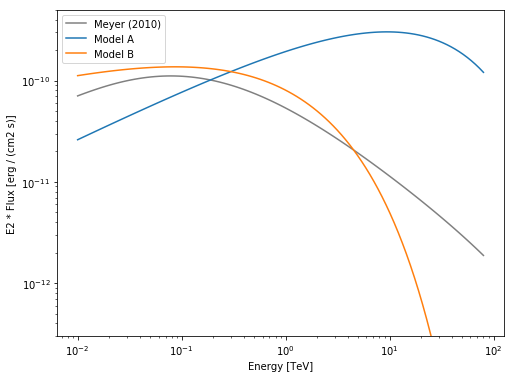

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))

opts = {
    "energy_range": [10 * u.GeV, 80 * u.TeV],
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

# Show Meyer et al. (2010) Crab spectrum as reference
model_meyer = CrabSpectrum("meyer").model
model_meyer.plot(label="Meyer (2010)", color="gray", **opts)

model_a = CrabSpectrumModel(
    amplitude="1e33 eV-1", e_0="10 TeV", alpha=2, e_cutoff="100 TeV"
)
model_a.plot(label="Model A", **opts)

model_b = CrabSpectrumModel(
    amplitude="2e33 eV-1", e_0="10 TeV", alpha=2.5, e_cutoff="10 TeV"
)
model_b.plot(label="Model B", **opts)

ax.set_ylim([3e-13, 5e-10])
plt.legend();

## Load data

We load the data from this paper using a helper function. The data consists of some Crab nebula observations from Fermi-LAT above 30 GeV, as well as data from MAGIC, VERITAS, FACT and HESS.

In [4]:
# Load the reduced spectral data as a `SpectrumObservationList`
# Options: 'joint', 'fermi','hess','magic','veritas', 'fact'
dataset = config.datasets["joint"]
obs_list = dataset.get_SpectrumObservationList()
print(f"Number of SpectrumObservation: {len(obs_list)}")

Number of SpectrumObservation: 10


## Model fit

Let's fit the model to the data. With this spectral model, the fit parameters are highly correlated. The reference energy `e_0 = "3 TeV"` was chosen to have reasonably small correlations. Already at 1 and 10 TeV the correlations are large.

In [5]:
%%time
model = CrabSpectrumModel(
    amplitude="1e34 eV-1", e_0="3 TeV", alpha=2.7, e_cutoff="10 TeV"
)
fit = SpectrumFit(
    obs_list=obs_list, model=model, fit_range=dataset.energy_range
)
results = fit.run(optimize_opts={"print_level": 0})

CPU times: user 1min 20s, sys: 265 ms, total: 1min 21s
Wall time: 27.1 s


## Fit results

Now let us look at the fit results.

In [6]:
print(results)

FitResult

	backend    : minuit
	method     : minuit
	success    : True
	nfev       : 187
	total stat : 460.27
	message    : Optimization terminated successfully.



In [7]:
print(results.model)

CrabSpectrumModel

Parameters: 

	   name     value     error   unit min max frozen
	--------- --------- --------- ---- --- --- ------
	amplitude 3.026e+34 1.228e+33 eV-1 nan nan  False
	      e_0 3.000e+00 0.000e+00  TeV nan nan   True
	    alpha 2.859e+00 9.627e-02      nan nan  False
	 e_cutoff 1.757e+01 2.869e+00  TeV nan nan  False

Covariance: 

	   name   amplitude     e_0      alpha    e_cutoff 
	--------- ---------- --------- --------- ----------
	amplitude  1.508e+66 0.000e+00 2.111e+30 -9.380e+32
	      e_0  0.000e+00 0.000e+00 0.000e+00  0.000e+00
	    alpha  2.111e+30 0.000e+00 9.269e-03  2.599e-01
	 e_cutoff -9.380e+32 0.000e+00 2.599e-01  8.228e+00


In [8]:
# You can get the fit results as a table
# that you can write to a file
results.model.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str4,float64,float64,bool
amplitude,3.026e+34,1.228e+33,eV-1,nan,nan,False
e_0,3.000e+00,0.000e+00,TeV,nan,nan,True
alpha,2.859e+00,9.627e-02,,nan,nan,False
e_cutoff,1.757e+01,2.869e+00,TeV,nan,nan,False


## Model SED

Let's compare the fitted model SED with the Meyer et al. (2010) reference Crab spectrum.

We find that the shape and amplitude is similar in the range covered by the data in this analysis (30 GeV to 20 TeV).

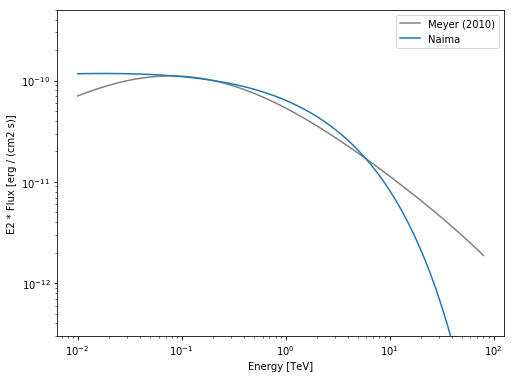

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

opts = {
    "energy_range": [10 * u.GeV, 80 * u.TeV],
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

# Show Meyer et al. (2010) Crab spectrum as reference
model_meyer = CrabSpectrum("meyer").model
model_meyer.plot(label="Meyer (2010)", color="gray", **opts)

results.model.plot(label="Naima", **opts)

ax.set_ylim([3e-13, 5e-10])
plt.legend();

## Conclusions

In this notebook, we have have defined a physical SED model using Naima and fit it to the gamma-ray data using Gammapy. To allow the use of Naima with Gammapy, we had to write a spectral model class which wraps the Naima spectral model classes. This is something that we hope to improve in the future, to integrate the two packages better.